In [1]:
from fastai2.vision.all import *
from utils import list_files
from fastai2.metrics import accuracy

In [2]:
data_dir = Path('/content/data')

In [3]:
list_files(data_dir)

data/
    sample_submission.csv
    test.csv
    train.csv
    train/
        ISIC_0015719.jpg
        ISIC_0052060.jpg
        ISIC_0052212.jpg
        ...
    test/
        ISIC_0052060.jpg
        ISIC_0052349.jpg
        ISIC_0058510.jpg
        ...


In [4]:
train_df = pd.read_csv(data_dir/'train.csv')
train_df.count()

image_name                       33126
patient_id                       33126
sex                              33061
age_approx                       33058
anatom_site_general_challenge    32599
diagnosis                        33126
benign_malignant                 33126
target                           33126
tfrecord                         33126
width                            33126
height                           33126
dtype: int64

In [7]:
batch_tfms = [*aug_transforms(size=224, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)]

In [8]:
db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader('image_name', pref=data_dir / 'train', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader('benign_malignant'),
                   item_tfms=Resize(460),
                   batch_tfms=batch_tfms)

In [9]:
dls = db.dataloaders(train_df)

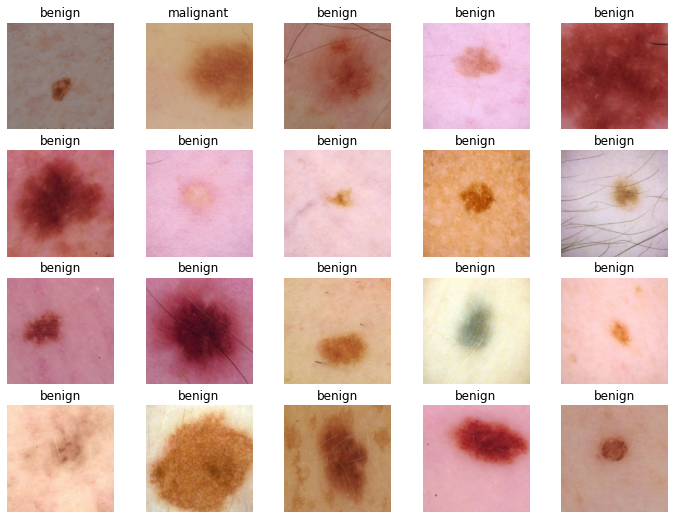

In [10]:
dls.show_batch(max_n=20, figsize=(12,9))

In [11]:
learn = cnn_learner(dls, resnet50, pretrained=True,metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.5248074531555176)

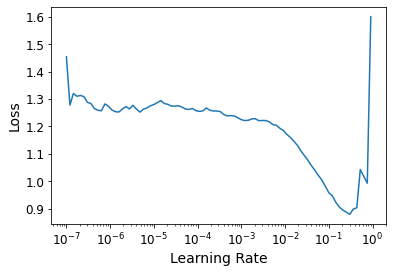

In [12]:
learn.lr_find()

In [13]:
lr = 2e-2
learn = learn.to_fp16()

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.126490,0.101976,0.980226,05:03
1,0.083084,0.077258,0.980830,05:01
2,0.080729,0.074430,0.980830,05:02
3,0.063614,0.069055,0.980830,05:04
4,0.056900,0.069690,0.981132,05:07


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [15]:
learn.save('stage-1')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=9.12010818865383e-07)

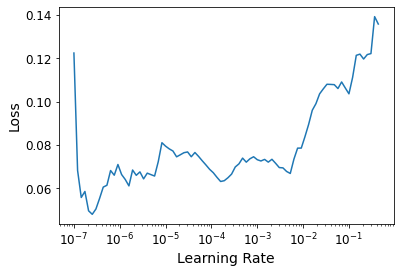

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
learn.fit_one_cycle(2, slice(4e-07, lr/5), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.063841,0.079464,0.980830,05:15
1,0.058809,0.068945,0.981736,05:10


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [20]:
learn.save('./stage-2')

In [31]:
test_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'));test_df

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [19]:
dl = learn.dls.test_dl(test_df)

In [34]:
preds = learn.tta(dl=dl)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [35]:
preds[0].shape

torch.Size([10982, 2])

In [36]:
test_df['target'] = preds[0].argmax(dim=1)

In [38]:
test_df.to_csv("submission.csv", index=False)

In [30]:
test_df

,image_name,target,label
0,ISIC_0052060,0,0
1,ISIC_0052349,0,0
2,ISIC_0058510,0,0
3,ISIC_0073313,0,0
4,ISIC_0073502,0,0
...,...,...,...
10977,ISIC_9992485,0,0
10978,ISIC_9996992,0,0
10979,ISIC_9997917,0,0
10980,ISIC_9998234,0,0
